# Simple Isochrone Method to identify uncovered areas

High level description of all steps:

1. Get service area polygon: For now, I just get boundaries that Brian had produced.
2. Get the boundary box of the service area: A box that surround the zip code.
3. Get a larger box that hopefully will include all possible close providers: For now, I just add 15 miles to each side of the box. I call this `inclusive_bounding_box`.
4. Get the graph inside this large box: This takes ~2 minutes. We can improve by saving the graphs for all zip codes.
5. Fetch all point As inside the zip code: I get the first 30 points for now.
6. Create isochrones from each point A: this will return all graph nodes that are inside the isochrone.
7. Create a convex hull of all the above points: this can be improved by creating a concave hull instead.
8. Select a subset of providers that could potentially cover the service area: I heuristically chose all providers in counties around the county that the zip code is in (Amador). There was no provider in Amador county. This step can be improved as well.
9. Geocode all provider addresses: I used OSM. We should compare with Google and Mapbox.
10. For each provider, test wether it is within each isochrones or not: create two lists, one for point As that the provider covers, and one for all point As that the provider does not cover.
11. Find Point As that are not covered.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pymongo
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely import geometry
from descartes import PolygonPatch
import pickle

from backend.models.time_distance_model import TimeDistanceModel
from backend.models.time_distance_model import enlarge_box
from backend.models import handle_points
from backend.models import isoline
from backend.models.geocode import Geocoder
from backend.models.distance import HaversineDistance
from backend.models.fetch_zips import fetch_zip_boundary_polygons

import warnings
warnings.filterwarnings('ignore')

client = pymongo.MongoClient('mongo', 27017)
na_db = client['na-db']

Let's start by picking a zip code. This is a rural area south of lake tahoe, not too far from Folsom.

In [4]:
zip_code = '95666'
county_name='Amador'

I am going to fetch the zip boundary from USPS API [here](https://gis.usps.com/arcgis/rest/services/EDDM/EDDM_ZIP5/MapServer/1).

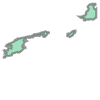

In [5]:
fetched_obj = fetch_zip_boundary_polygons([zip_code])
zip_geometry = fetched_obj['features'][0]['geometry']
zip_polygon = geometry.shape(zip_geometry)
zip_polygon

This zip code has an unusual shape.

Next, I create an instance of isochrone model, and create a large boundary box around the zip code above.

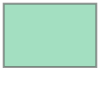

In [6]:
osmisoliner = isoline.OSMIsonliner()
isoline_model = TimeDistanceModel(osmisoliner.get_single_isodistance_polygon, service_area=zip_polygon)

isoline_model.clear_graph()
isoline_model.set_inclusive_bounding_box()

We need to get the graph inside this large box. This will take ~2 minutes.

In [7]:
%time isoline_model.fetch_graph()

CPU times: user 3min 34s, sys: 7.46 s, total: 3min 41s
Wall time: 4min 28s


Cool. Now, we have the graph. Let's find our Point As. I pick the first 30 point As, and find their respective isochrones.

In [8]:
point_as = handle_points.fetch_point_as(na_db, zip_code, county_name)
_ = isoline_model.build_all_isolines(point_as[:30], 15)

Ok. Next up, let's load all providers' addresses. I am only interested in close providers. So, I choose the ones in Amador or neighboring counties. Found them from [this map](http://geology.com/county-map/california.shtml).

In [9]:
csv_path = '../../data/all_pcps_addresses.csv'
providers = handle_points.fetch_provider_addresses(csv_path)
close_providers = providers[providers.County.isin(['Amador', 'Sacramento', 'El Dorado', 'Calaveras', 'San Joaquin', 'Alpine'])]
print('After filtering for close providers, there are {} rows in the df.'.format(close_providers.shape[0]))

There are 6157 unique addresses in this file.
After filtering for close providers, there are 295 rows in the df.


I have to geocode them all close providers. On OSM, this takes ~7:30 minutes. But we can save the results. Instead you can load data from the pickle file.

In [28]:
geocoder = Geocoder()
%time close_providers_geocodes = close_providers.full_address.apply(geocoder.geocode)

CPU times: user 11.7 s, sys: 1.18 s, total: 12.9 s
Wall time: 7min 30s


In [10]:
with open('data.pkl', 'rb') as pkl_file:
    close_providers_geocodes = pickle.load(pkl_file)

In [11]:
msg_base = 'Was able to geocode {} out of {} addresses. {:.2f}% success rate.'
total = len(close_providers_geocodes)
success_count = close_providers_geocodes.count()
print(msg_base.format(success_count, total, success_count * 100 / total))

Was able to geocode 243 out of 295 addresses. 82.37% success rate.


Now, for each provider, I see which isochrones it falls into. I create two lists for each provider: `covering_points` and `not_covering_points`, which are point As that this provider is and is not covering respectively.

In [12]:
close_providers['geo_location'] = close_providers_geocodes
close_providers[['covering_points', 'not_covering_points']] = close_providers.geo_location.apply(isoline_model.if_single_provider_within_all_isolines)

In [13]:
covered_point_as = set(close_providers.covering_points.apply(pd.Series).stack().unique())
all_point_as = set(close_providers.not_covering_points.apply(pd.Series).stack().unique())
non_covered_point_as = all_point_as - covered_point_as
print('List of covered point As: {}'.format(covered_point_as))
print('In this zip code, {} out of {} point As are covered.'.format(len(covered_point_as), len(all_point_as)))

List of covered point As: {1.0, 6.0, 14.0, 17.0, 18.0, 27.0, 28.0}
In this zip code, 7 out of 30 point As are covered.


Let's plot all isochrones, provider, and point A locations on a map.

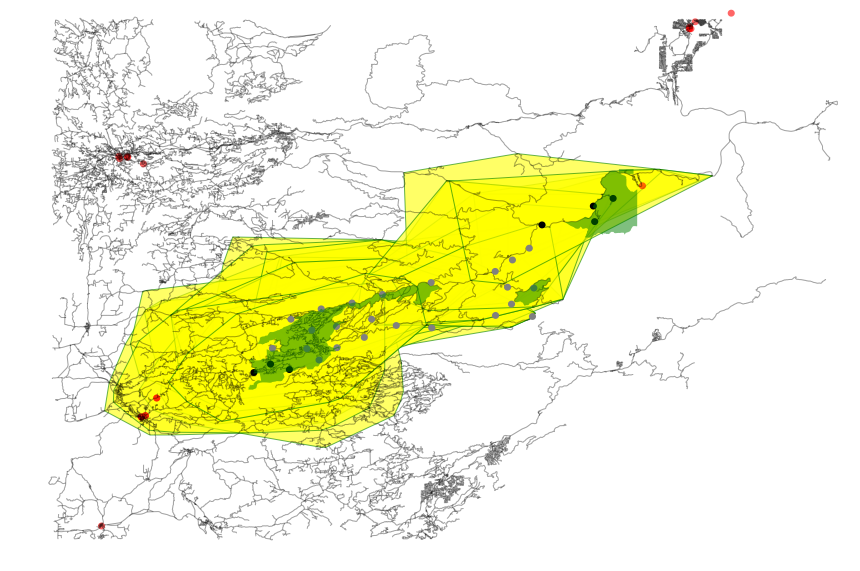

In [14]:
fig, ax = ox.plot_graph(isoline_model.graph, fig_height=10, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
patch = PolygonPatch(zip_polygon, fc='green', ec='none', alpha=0.5, zorder=3)
ax.add_patch(patch)
for _, isochrones in isoline_model.all_isolines:
    patch = PolygonPatch(isochrones, fc='yellow', ec='green', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
for p in close_providers_geocodes:
    if p:
        patch = PolygonPatch(p.buffer(0.005), fc='red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
for p_id in list(map(int, covered_point_as)):
    p = point_as[p_id]
    patch = PolygonPatch(p.buffer(0.005), fc='black', ec='none', alpha=1, zorder=1)
    ax.add_patch(patch)
for p_id in list(map(int, non_covered_point_as)):
    p = point_as[p_id]
    patch = PolygonPatch(p.buffer(0.005), fc='grey', ec='none', alpha=1, zorder=2)
    ax.add_patch(patch)

plt.show()

Ok from this map, it is obvious that our zip code polygon is not accurate enough. It does not include that right hand side point As. Therefore, the resulting bounding box is smaller that it should be. and thus the isochornes are not accurate.

Now, for the rest of point As, I am going to find the distance between each of them and all other point Bs. For now, I just use Hoversine distance measurement.

In [16]:
distancer = HaversineDistance()

In [17]:
distance_res = pd.DataFrame(columns=range(len(close_providers_geocodes)))
total_number_of_distance_measurements = 0
for far_point_a_id in list(map(int, non_covered_point_as)):
    far_point_a = point_as[far_point_a_id]
    far_point_a_provider_distance = []
    for provider in list(close_providers_geocodes):
        # Only look at providers inside the bbox.
        if isoline_model._is_point_within_polygon(provider, geometry.Polygon(isoline_model.bounding_box)):
            total_number_of_distance_measurements += 1
            d = distancer.get_distance_in_miles(far_point_a, provider)
        else:
            d = None
        far_point_a_provider_distance.append(d)
    distance_res.loc[far_point_a_id] = pd.Series(far_point_a_provider_distance)
print('I have run {} distance API calls.'.format(total_number_of_distance_measurements))
distance_res.dropna(axis=1, inplace=True)
distance_res.head()

I have run 414 distance API calls.


,53,54,71,72,108,117,137,152,153,193,213,219,220,233,278,280,281,284
0,23.798169,44.124708,43.315373,12.497388,24.019462,43.315373,14.048925,23.550001,30.359311,12.497388,14.392644,43.388171,43.442915,23.720081,23.597711,14.048925,14.392644,22.314636
2,32.688107,33.109756,32.289249,27.186480,32.851156,32.289249,28.585875,32.220068,17.150272,27.186480,28.931063,32.338487,32.442717,36.800171,32.259396,28.585875,28.931063,30.846806
3,24.219333,36.230500,35.418587,20.129352,24.398607,35.418587,21.807082,23.795294,22.614860,20.129352,22.146137,35.489947,35.548221,31.624346,23.837332,21.807082,22.146137,22.429716
4,32.479238,25.953824,25.131700,32.171340,32.599676,25.131700,33.781996,31.929536,10.650369,32.171340,34.124786,25.183974,25.282672,42.949986,31.961511,33.781996,34.124786,30.592371
5,29.227280,36.640363,35.817555,22.167783,29.409935,35.817555,23.591453,28.812902,21.466117,22.167783,23.936839,35.876686,35.961893,32.137002,28.855392,23.591453,23.936839,27.450315


In [19]:
farthest_point_a_id = distance_res.min(axis=1, skipna=True).idxmax()
farthest_point_a_closest_providers_id = distance_res.loc[farthest_point_a_id].sort_values()[:10]
print('The farthest point A from any provider is point #{}.'.format(farthest_point_a_id))
print('Here is the list of its distance from closest 10 providers:\n{}'.format(farthest_point_a_closest_providers_id))

The farthest point A from any provider is point #5.
Here is the list of its distance from closest 10 providers:
153    21.466117
72     22.167783
193    22.167783
280    23.591453
137    23.591453
213    23.936839
281    23.936839
284    27.450315
152    28.812902
278    28.855392
Name: 5, dtype: float64


Let's plot all these on map.

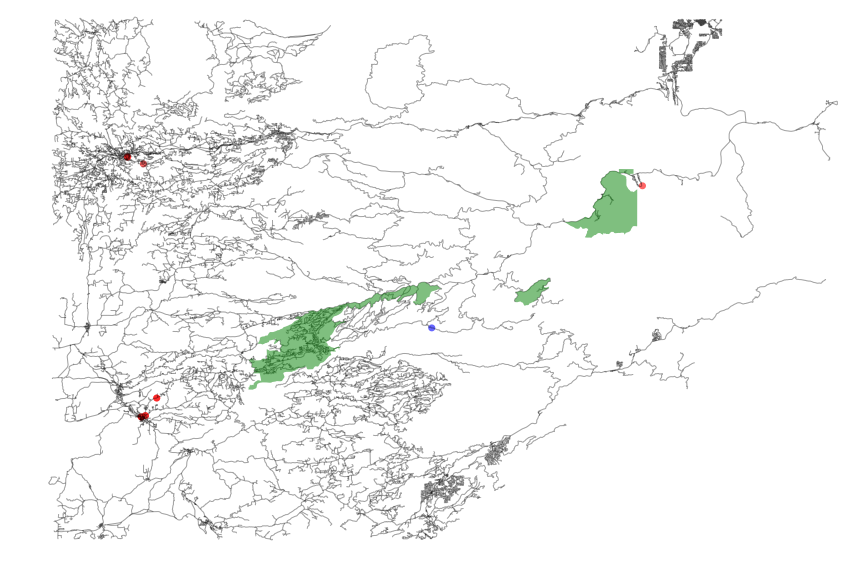

In [20]:
fig, ax = ox.plot_graph(isoline_model.graph, fig_height=10, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
patch = PolygonPatch(zip_polygon, fc='green', ec='none', alpha=0.5, zorder=3)
ax.add_patch(patch)
patch = PolygonPatch(point_as[int(farthest_point_a_id)].buffer(0.005), fc='blue', ec='none', alpha=0.6, zorder=-1)
ax.add_patch(patch)
for p_id in list(map(int, list(farthest_point_a_closest_providers_id.index))):
    p = list(close_providers_geocodes)[p_id]
    if p:
        patch = PolygonPatch(p.buffer(0.005), fc='red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
plt.show()